<a href="https://colab.research.google.com/github/LudovicaCi/CIDL_Project/blob/main/CNN_training_unbalanced_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and install

In [ ]:
!pip install tensorflow

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.layers import BatchNormalization
from keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras.metrics import Metric
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import resample

# Upload dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# setup directory for training and test dataset
train_path = '/content/drive/Shareddrives/Cocchella_Cantini/Dataset/train'
test_path = '/content/drive/Shareddrives/Cocchella_Cantini/Dataset/test'

In [ ]:
# Create a dictionary to map class indices to class names
classes = {
    0: 'angry',
    1: 'disgusted',
    2: 'fearful',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprised'
}

## Create Train and Validation set

In [ ]:
#we put all image with classes in np array
image_data = []
image_labels = []

for class_index in classes.keys():
  path = train_path + '/' + str(class_index)
  images = os.listdir(path)

  for img in tqdm(images, desc=f"Class {class_index}"):
        try:
            image_path = path + '/' + img
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image_data.append(np.array(image))
            image_labels.append(class_index)
        except:
            print("Error in " + img)

# Convert the list into a numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

Class 6: 100%|██████████| 3171/3171 [00:48<00:00, 65.29it/s] 

(28709, 48, 48) (28709,)


In [ ]:
# Save numpy array
np.save('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/image_data_gray_np.npy', image_data)
np.save('/content/drive/Shareddrives/CIDL/Dataset/labels_data_gray_np.npy', image_labels)

In [ ]:
# Upload array
image_data = np.load('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/image_data_gray_np.npy')
image_labels = np.load('/content/drive/Shareddrives/CIDL/Dataset/labels_data_gray_np.npy')

In [ ]:
#we mix the array, so when we go to create train, test and validation, we avoid having a predominance of classes
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [ ]:
# Split the data and labels into training and validation sets using an 80 - 20 split ratio.
img_train, img_val, label_train, label_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

# Print the shapes of the resulting datasets to confirm the split and normalization.
print("Training data shape:", img_train.shape)
print("Validation data shape:", img_val.shape)
print("Training labels shape:", label_train.shape)
print("Validation labels shape:", label_val.shape)

Training data shape: (22967, 48, 48)
Validation data shape: (5742, 48, 48)
Training labels shape: (22967,)
Validation labels shape: (5742,)


(22967, 48, 48)
uint8


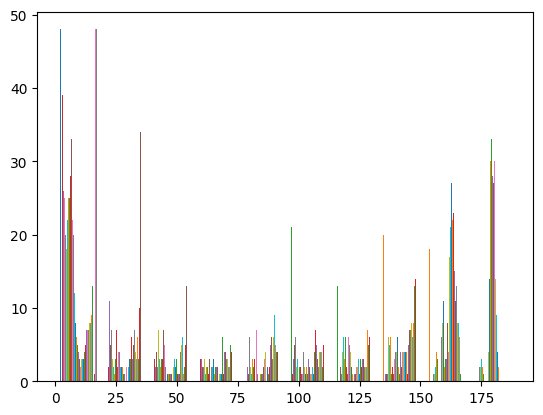

In [ ]:
final_img_train_np = img_train
final_img_valid_np = img_val
final_label_train_np = label_train
final_label_valid_np = label_val


print(final_img_train_np.shape)

print(final_img_train_np[0].dtype) # check the type
plt.hist(final_img_train_np[0]) # check the value range and the distribution
plt.show()


float32


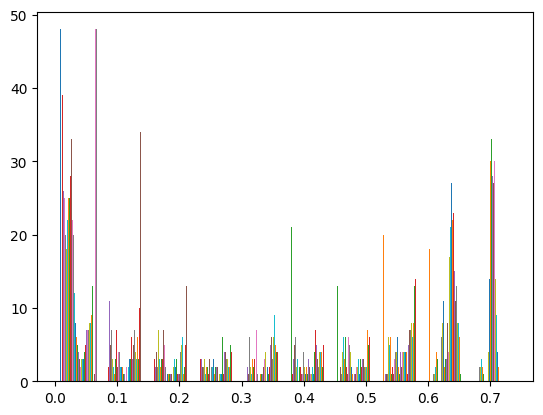

In [ ]:
img_train_norm = final_img_train_np.astype('float32') / 255
img_val_norm = final_img_valid_np.astype('float32') / 255

print(img_train_norm[0].dtype)
plt.hist(img_train_norm[0])
plt.show()


In [ ]:

print(img_train_norm.shape)
print(img_train_norm.shape[1])
print(img_train_norm.shape[2])
img_train_norm = img_train_norm.reshape(img_train_norm.shape[0], img_train_norm.shape[1], img_train_norm.shape[2], 1)
img_val_norm = img_val_norm.reshape(img_val_norm.shape[0], img_val_norm.shape[1], img_val_norm.shape[2], 1)


(22967, 48, 48)
48
48


In [ ]:
# Convert labels to categorical format
categorical_label_train = to_categorical(final_label_train_np)
categorical_label_val = to_categorical(final_label_valid_np)

In [ ]:
print(categorical_label_train[0])
print(categorical_label_val[0])

[1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]


# CNN IMPLEMENTATION FROM SCRATCH

## Final Model

In [ ]:
# Define the CNN model

model = models.Sequential()

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(48, 48, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# Third convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# fifth convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# seventh convolutional layer
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# Flattening Layer
model.add(layers.Flatten())

# first dense layer
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# third dense layer (output)
model.add(layers.Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(final_label_train_np),
    y=final_label_train_np)
class_weight_dict = dict(enumerate(class_weights))

# Create ImageDataGenerator object with data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# Create an instance of EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=10,             # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore the model with the best weights
)

checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/Shareddrives/Cocchella_Cantini/models/CnnModelFromScratch.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True)

# Train the model with data augmentation and class weights
history = model.fit(
    datagen.flow(img_train_norm, categorical_label_train, batch_size=64),
    epochs=200,
    callbacks=[early_stopping, checkpoint],
    validation_data=(img_val_norm, categorical_label_val),
    class_weight=class_weight_dict,
    shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 2.3787 - accuracy: 0.1739

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 37s 49ms/step - loss: 2.3787 - accuracy: 0.1739 - val_loss: 2.1159 - val_accuracy: 0.0221
Epoch 2/200
359/359 [==============================] - 16s 45ms/step - loss: 1.9738 - accuracy: 0.2246 - val_loss: 1.8218 - val_accuracy: 0.2630
Epoch 3/200
359/359 [==============================] - 17s 47ms/step - loss: 1.7769 - accuracy: 0.2994 - val_loss: 1.6142 - val_accuracy: 0.3697
Epoch 4/200
359/359 [==============================] - 16s 45ms/step - loss: 1.6327 - accuracy: 0.3586 - val_loss: 1.6871 - val_accuracy: 0.3406
Epoch 5/200
359/359 [==============================] - 16s 45ms/step - loss: 1.5211 - accuracy: 0.4040 - val_loss: 1.3894 - val_accuracy: 0.4716
Epoch 6/200
359/359 [==============================] - 17s 48ms/step - loss: 1.4701 - accuracy: 0.4335 - val_loss: 1.3064 - val_accuracy: 0.4974
Epoch 7/200
359/359 [==============================] - 16s 45ms/step - loss: 1.4168 - accuracy: 0.4509 - val_loss: 1.3797 - val_accuracy: 0.47

## Evaluation and Test


In [ ]:
from sklearn import metrics
import seaborn as sn

def evaluateClassifier(model, testset, actual):
  font = {'size'   : 16}
  plt.rc('font', **font)
  pred = model.predict(testset)

  y_classes = pred.argmax(axis=-1)
  y_classes = to_categorical(y_classes)

  y_test_non_category = [ np.argmax(t) for t in actual ]
  y_predict_non_category = [ np.argmax(t) for t in y_classes ]
  conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
  print(metrics.classification_report(y_test_non_category, y_predict_non_category))

  # plot confusion matrix
  group_counts = ['{:.0f}'.format(value) for value in conf_mat.flatten()]
  group_percentages = [('{:.2f}'.format(value))[1:] for value in (conf_mat / np.sum(conf_mat, axis=1)).flatten()]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(7,7) # 7 is the number of classes
  fig, ax = plt.subplots(figsize=(11,10))
  plt.title('Confusion matrix')
  sn.heatmap(conf_mat, annot=labels, fmt='', cmap="OrRd", ax=ax)
  font = {'size'   : 20}
  plt.rc('font', **font)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()



def plot_accurancy_loss(hist):
  """ utility function to plot training and validation curves"""

  plt.rcParams["figure.figsize"] = (7,5)
  font = {'size'   : 24}
  plt.rc('font', **font)

  acc_1 = hist.history['accuracy']
  val_acc_1 = hist.history['val_accuracy']
  loss_1 = hist.history['loss']
  val_loss_1 = hist.history['val_loss']
  epochs = range(len(acc_1))

  plt.figure()
  plt.plot(epochs, loss_1, 'C1', alpha=0.6, label='Training loss', linewidth=3.5)
  plt.plot(epochs, val_loss_1, 'C2', alpha=0.6, label='Validation loss', linewidth=3.5)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(prop={'size': 24}, loc="upper right")
  plt.show()

  plt.ylim(0,1)
  plt.plot(epochs, acc_1, 'C1', alpha=0.6, linewidth=3.5, label='Training acc')
  plt.plot(epochs, val_acc_1, 'C2', alpha=0.6, linewidth=3.5, label='Validation acc')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(prop={'size': 24}, loc="lower right")

  plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def evaluateClassifier(model, testset, actual, num_examples=5):
    font = {'size': 16}
    plt.rc('font', **font)
    pred = model.predict(testset)

    y_classes = pred.argmax(axis=-1)
    y_classes = to_categorical(y_classes)

    y_test_non_category = [np.argmax(t) for t in actual]
    y_predict_non_category = [np.argmax(t) for t in y_classes]
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    print(metrics.classification_report(y_test_non_category, y_predict_non_category))

    # Calcola il numero di misclassificazioni per ciascuna classe
    misclass_counts = [sum((y_test_non_category[i] == true_label) and (y_predict_non_category[i] != true_label) for i in range(len(y_test_non_category))) for true_label in range(len(conf_mat))]

    # Ordina le classi in base al numero di misclassificazioni (in ordine decrescente)
    sorted_classes = sorted(range(len(misclass_counts)), key=lambda i: misclass_counts[i], reverse=True)

    # Identifica gli indici degli esempi di classificazione errata
    misclassified_indices = [i for i in range(len(y_test_non_category)) if y_test_non_category[i] != y_predict_non_category[i]]

    # Estrai casualmente num_examples indici dagli esempi di classificazione errata
    selected_indices = np.random.choice(misclassified_indices, num_examples, replace=False)

    # Crea una sottolista di immagini e etichette corrispondenti utilizzando gli indici selezionati
    selected_images = [testset[i] for i in selected_indices]
    selected_actual_labels = [y_test_non_category[i] for i in selected_indices]
    selected_predicted_labels = [y_predict_non_category[i] for i in selected_indices]

    # Plot delle immagini selezionate
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    for i in range(num_examples):
        axes[i].imshow(selected_images[i])
        axes[i].set_title(f'Actual: {selected_actual_labels[i]}\nPredicted: {selected_predicted_labels[i]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # Plot della matrice di confusione ordinata
    conf_mat_sorted = conf_mat[sorted_classes][:, sorted_classes]
    group_counts = ['{:.0f}'.format(value) for value in conf_mat_sorted.flatten()]
    group_percentages = [('{:.2f}'.format(value))[1:] for value in (conf_mat_sorted / np.sum(conf_mat_sorted, axis=1)).flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(len(sorted_classes), len(sorted_classes))
    fig, ax = plt.subplots(figsize=(11, 10))
    plt.title('Confusion matrix (sorted)')
    sn.heatmap(conf_mat_sorted, annot=labels, fmt='', cmap="OrRd", ax=ax)
    font = {'size': 20}
    plt.rc('font', **font)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
#we put all test image with classes in np array
image_test_np = []
label_test_np = []

for class_index in classes.keys():
  path = test_path + '/' + str(class_index)
  images = os.listdir(path)

  for img in tqdm(images, desc=f"Class {class_index}"):
        try:
            image_path = path + '/' + img
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image_test_np.append(np.array(image))
            label_test_np.append(class_index)
        except:
            print("Error in " + img)

# Convert the list into a numpy array
image_test_np = np.array(image_test_np)
label_test_np = np.array(label_test_np)


print(image_test_np.shape, label_test_np.shape)

Class 6: 100%|██████████| 831/831 [00:09<00:00, 87.35it/s] 


(7178, 48, 48) (7178,)


In [ ]:
# Save numpy array
np.save('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/image_test_gray_np.npy', image_test_np)
np.save('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/label_test_gray_np.npy', label_test_np)

In [ ]:
image_test_np = np.load('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/image_test_gray_np.npy')
label_test_np = np.load('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/label_test_gray_np.npy')

[3995  436 4097 7215 4965 4830 3171]


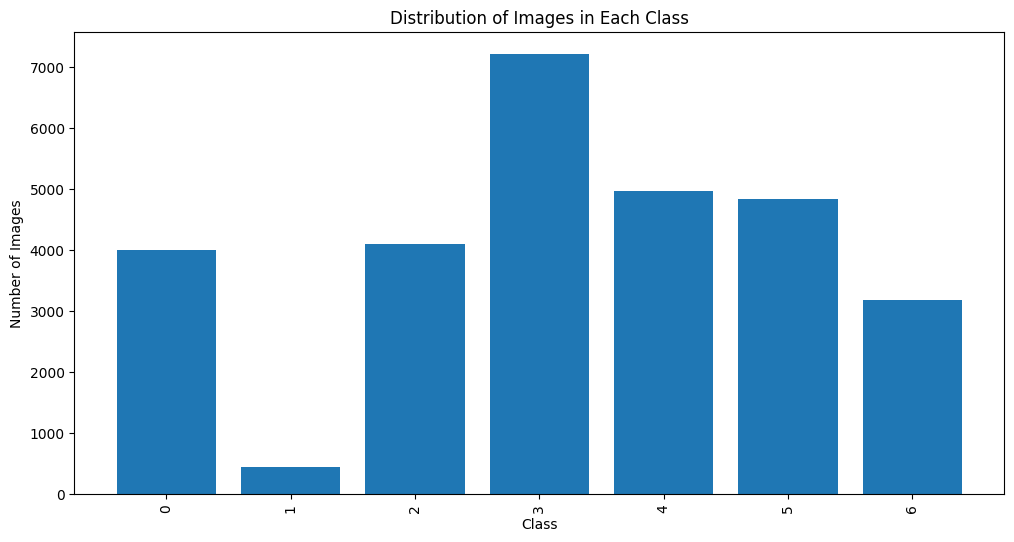

In [ ]:
# We'll see the distribution of our classes in the test set

# Array originale di numeri da 0 a 6
class_array = np.array([0,1,2,3,4,5,6])

# Creazione dell'array conteggio
count_array = np.zeros(7, dtype=int)  # Creiamo un array inizializzato con zeri

# Conteggio delle occorrenze
for num in image_labels:
    count_array[num] += 1

print(count_array)

# Plotting the number of images in each class
plt.figure(figsize=(12, 6))
plt.bar(class_array, count_array)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Images in Each Class")
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
image_test_norm = image_test_np.astype('float32') / 255

In [ ]:
# Upload trained model
model = tf.keras.models.load_model('/content/drive/Shareddrives/Cocchella_Cantini/models/CnnModelFromScratch.h5')

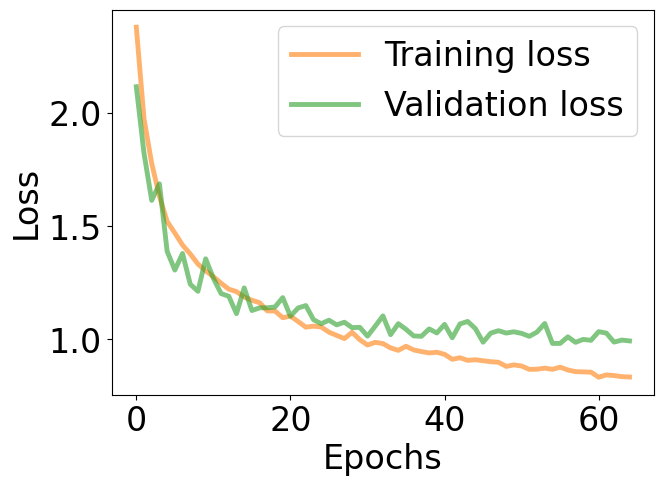

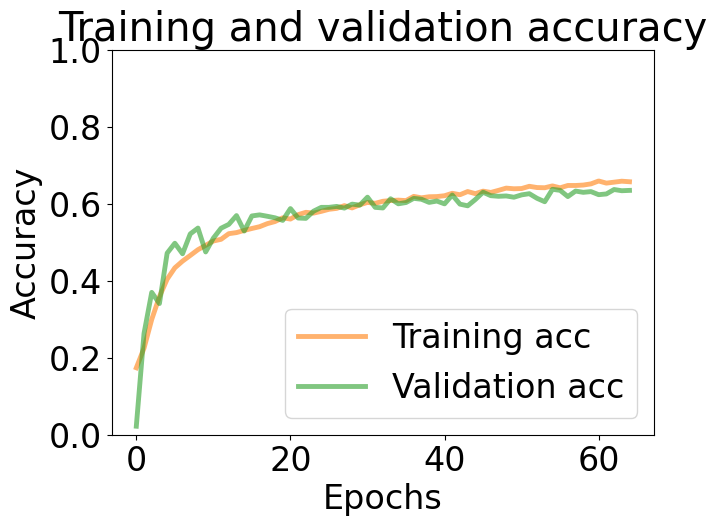

225/225 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.60      0.55      0.57       958
           1       0.64      0.72      0.68       111
           2       0.53      0.37      0.43      1024
           3       0.87      0.83      0.85      1774
           4       0.53      0.73      0.61      1233
           5       0.53      0.48      0.50      1247
           6       0.72      0.82      0.77       831

    accuracy                           0.64      7178
   macro avg       0.63      0.64      0.63      7178
weighted avg       0.65      0.64      0.64      7178



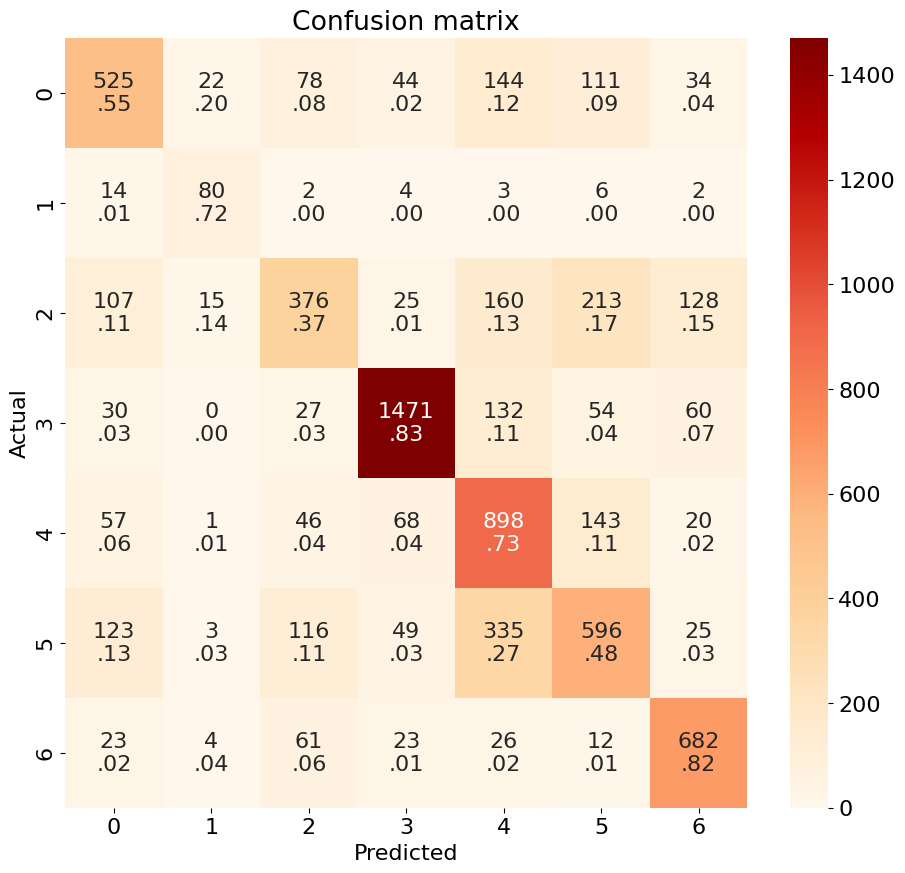

In [ ]:
# Convert labels to categorical format
categorical_label_test = to_categorical(label_test_np)

# reshape test set
image_test_norm = image_test_norm.reshape(image_test_norm.shape[0], image_test_norm.shape[1], image_test_norm.shape[2], 1)

plot_accurancy_loss(history)
evaluateClassifier(model, image_test_norm, categorical_label_test)

# Visualizing intermediate activations



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/Shareddrives/Cocchella_Cantini/models/CnnModelFromScratch.h5'

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
img_path = "/content/drive/Shareddrives/Cocchella_Cantini/Dataset/test/0/PrivateTest_10131363.jpg"
# We preprocess the image into a 4D tensor
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# Its shape is (1, 48, 48, 1)
print(img_tensor.shape)

(1, 48, 48, 1)


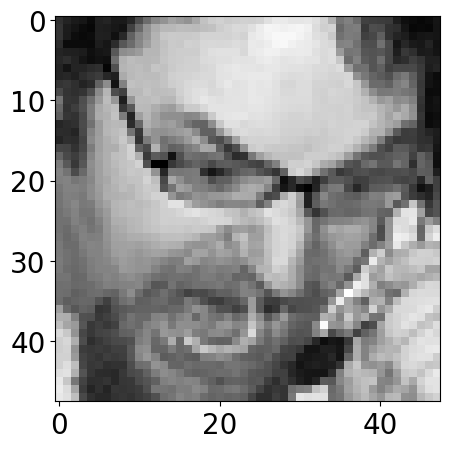

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0].astype('uint8'), cmap="gray")
plt.show()

In [ ]:
print(type(model.layers))
print(len(model.layers))
model.layers # is a list of layers

<class 'list'>
25


In [ ]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        print(layer.name)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

conv2d
conv2d_1
max_pooling2d
conv2d_2
conv2d_3
max_pooling2d_1
conv2d_4
max_pooling2d_2
conv2d_5
max_pooling2d_3


In [ ]:
# This will return a list of 8 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)
print(len(activations))
for out in activations:
  print(out.shape)

1/1 [==============================] - 0s 342ms/step
10
(1, 48, 48, 32)
(1, 48, 48, 32)
(1, 24, 24, 32)
(1, 24, 24, 64)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 128)
(1, 6, 6, 128)
(1, 6, 6, 256)
(1, 3, 3, 256)


In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 48, 48, 32)


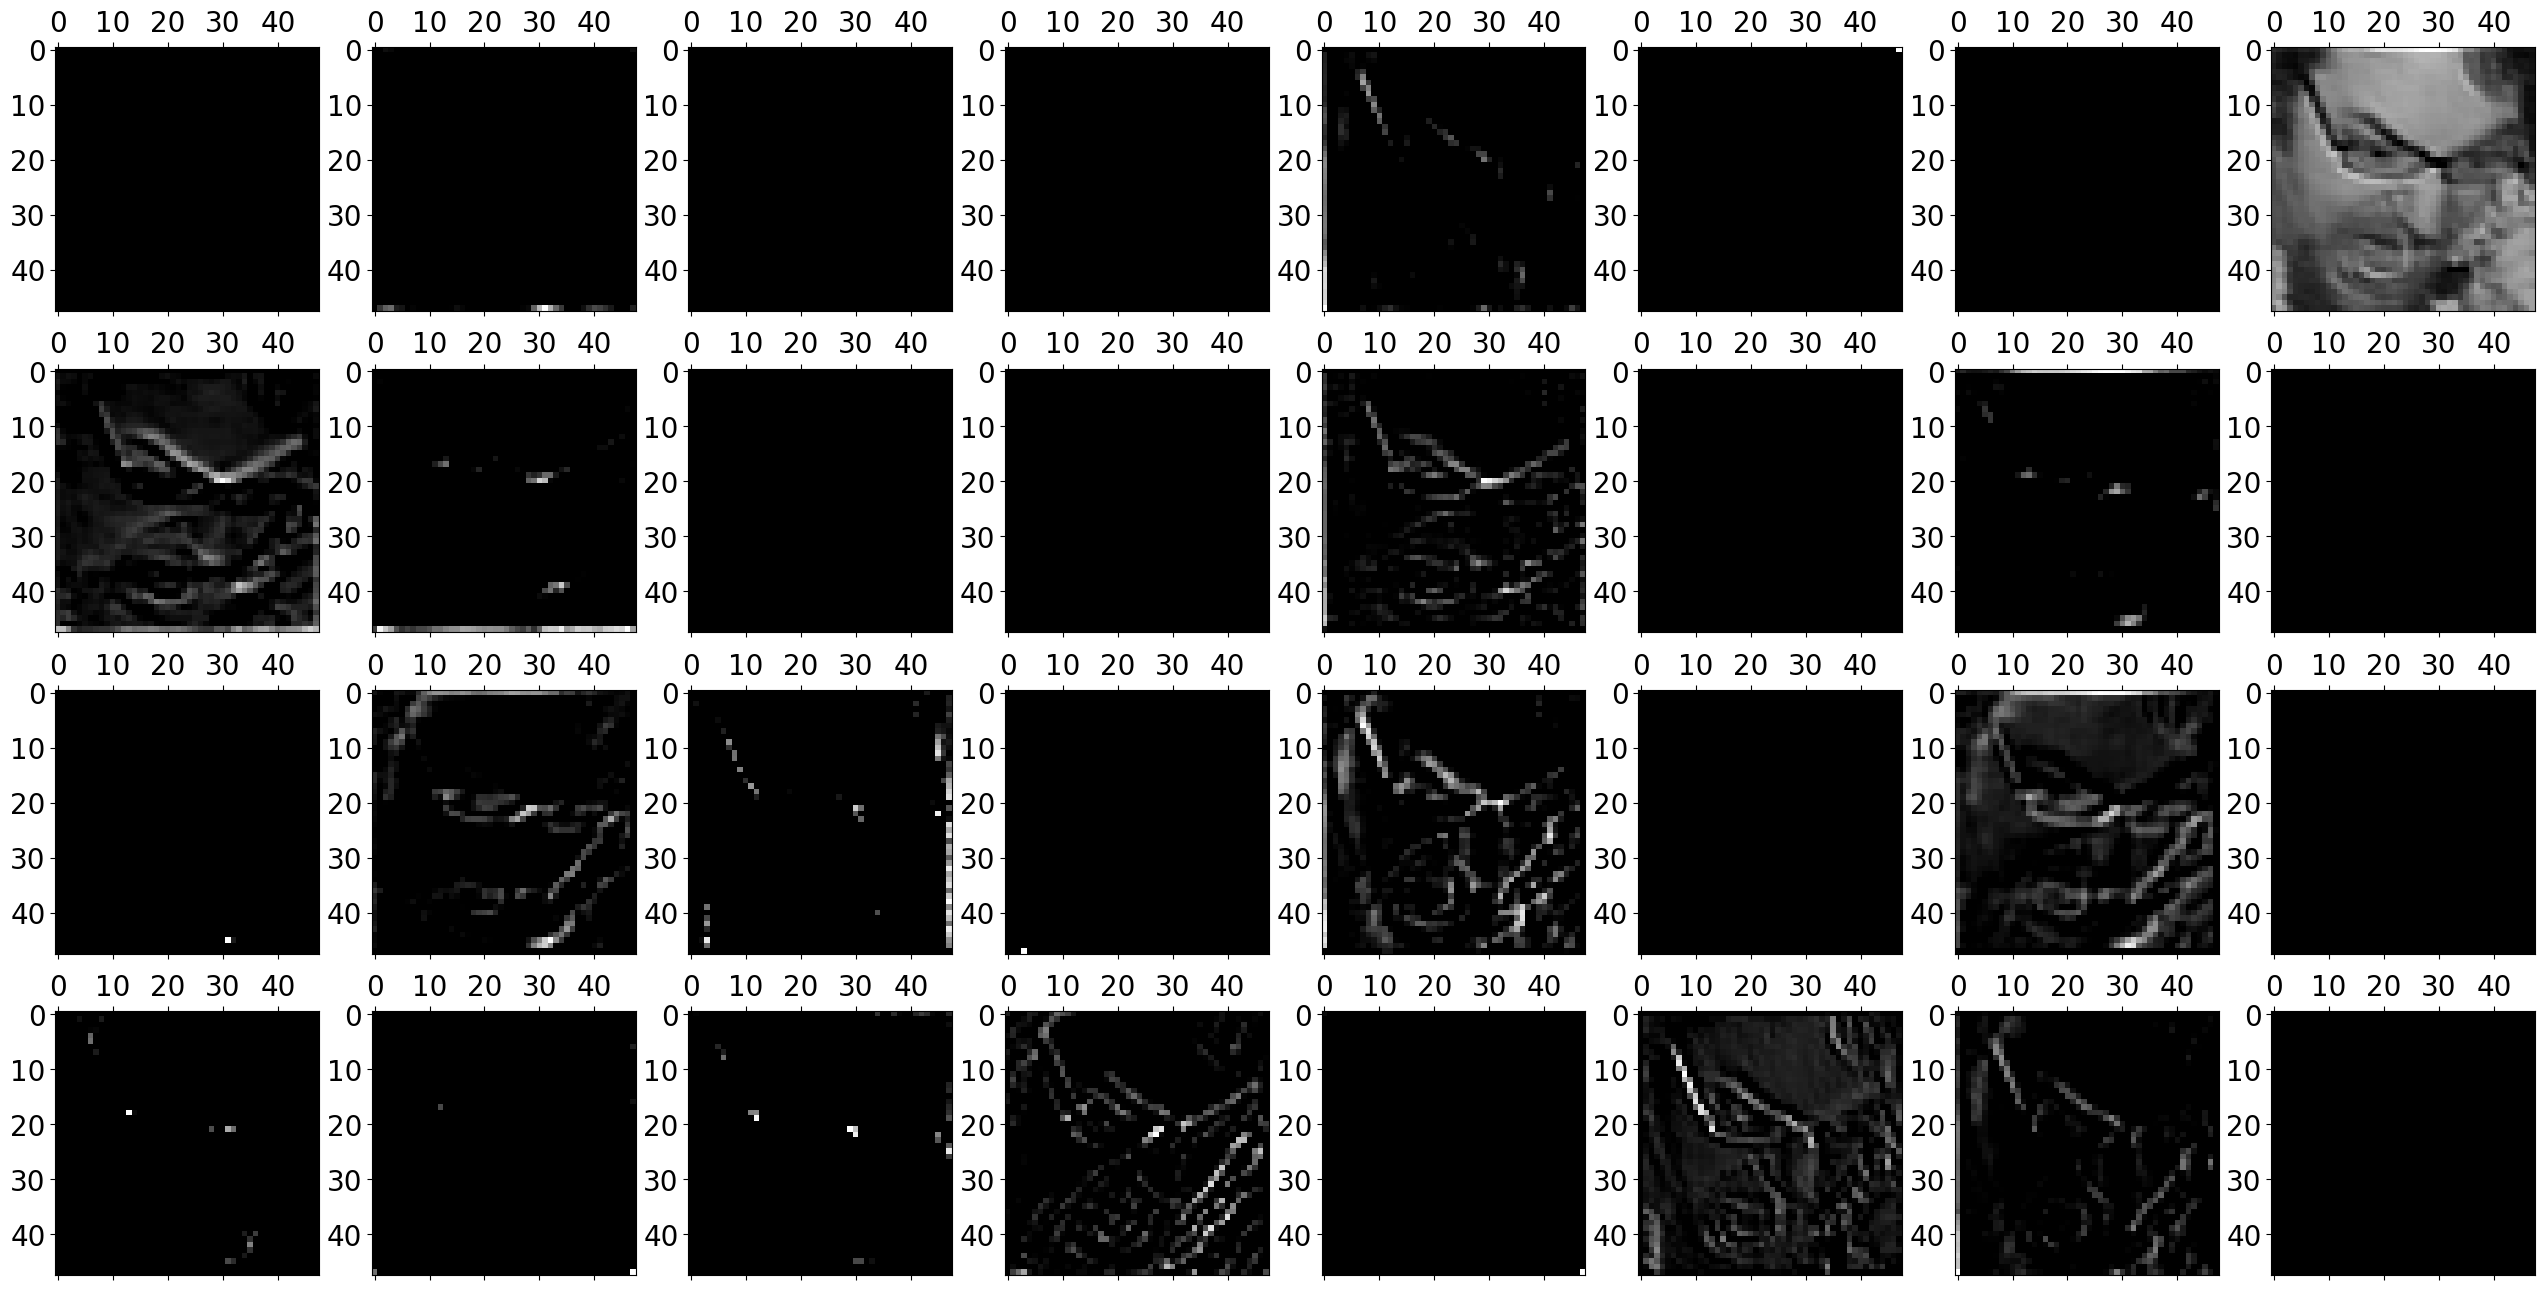

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 8, figsize=(32, 16))
for k in range(8):
    ax[0, k].matshow(first_layer_activation[0, :, :, k], cmap='gray')
    ax[1, k].matshow(first_layer_activation[0, :, :, k+8], cmap='gray')
    ax[2, k].matshow(first_layer_activation[0, :, :, k+16], cmap='gray')
    ax[3, k].matshow(first_layer_activation[0, :, :, k+24], cmap='gray')
plt.show()

In [ ]:
images_per_row = 16

<ipython-input-34-16e3923b1cb8>:19: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


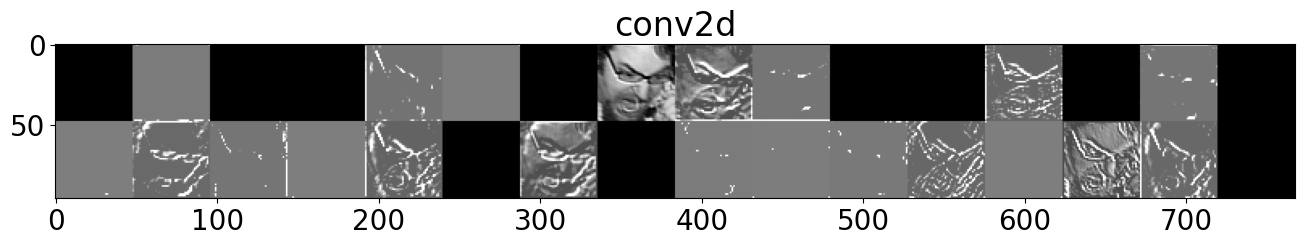

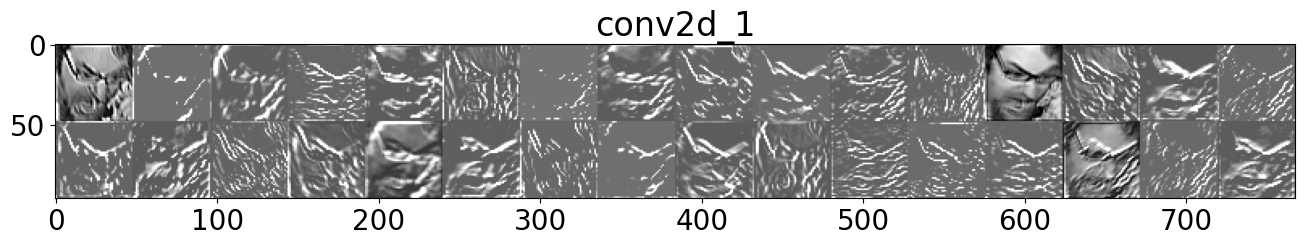

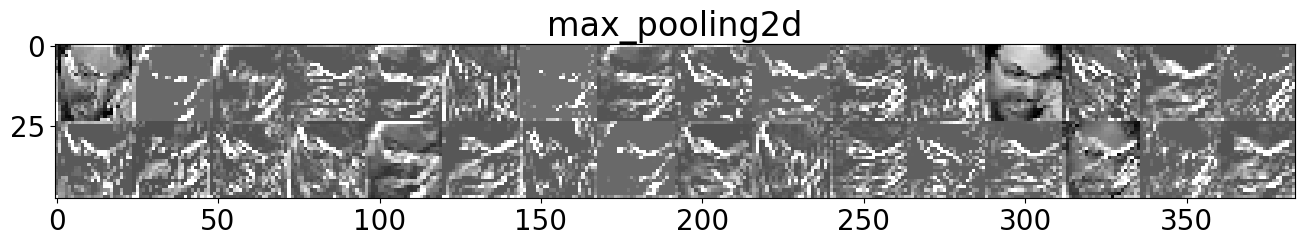

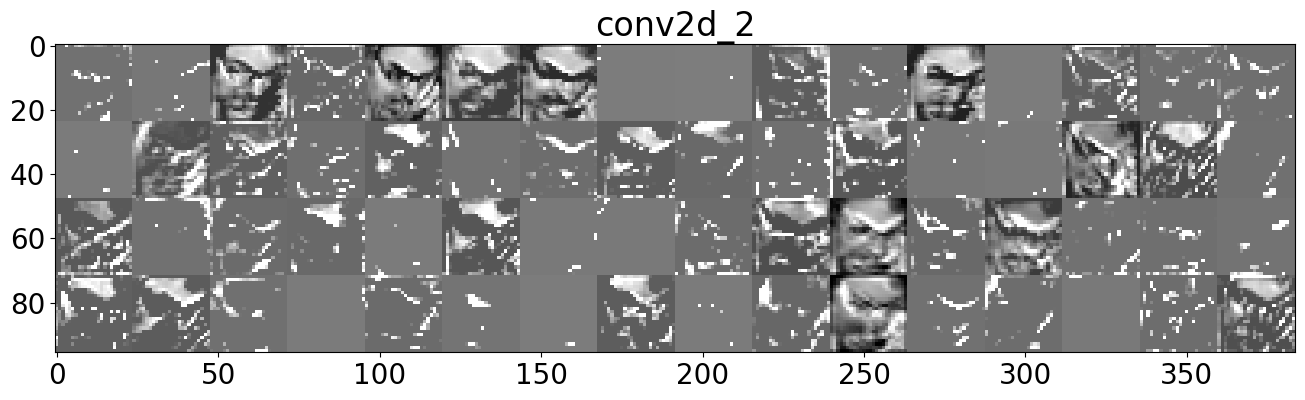

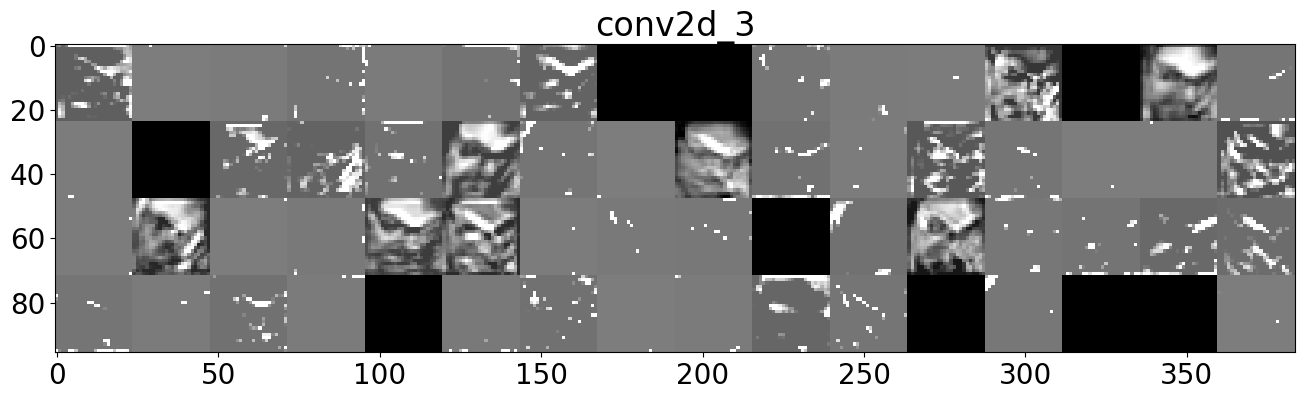

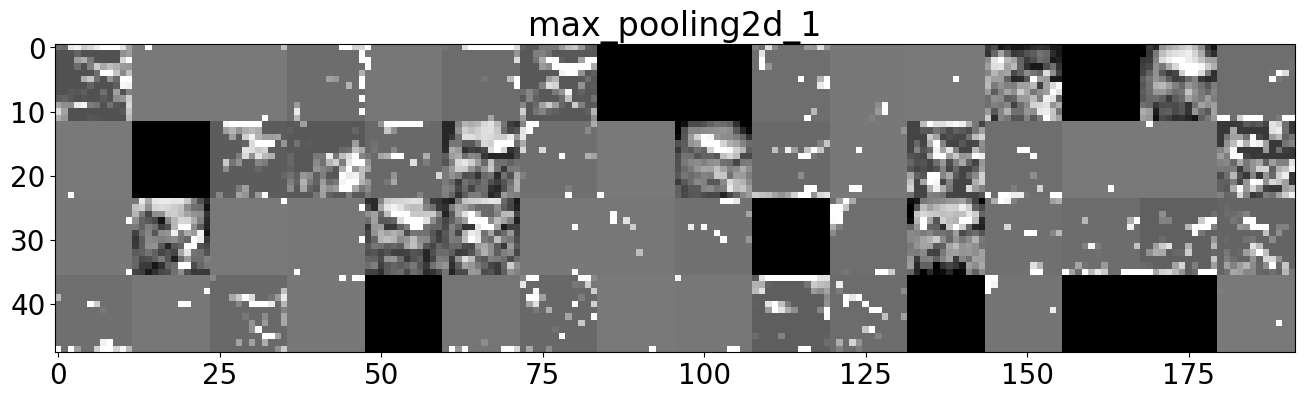

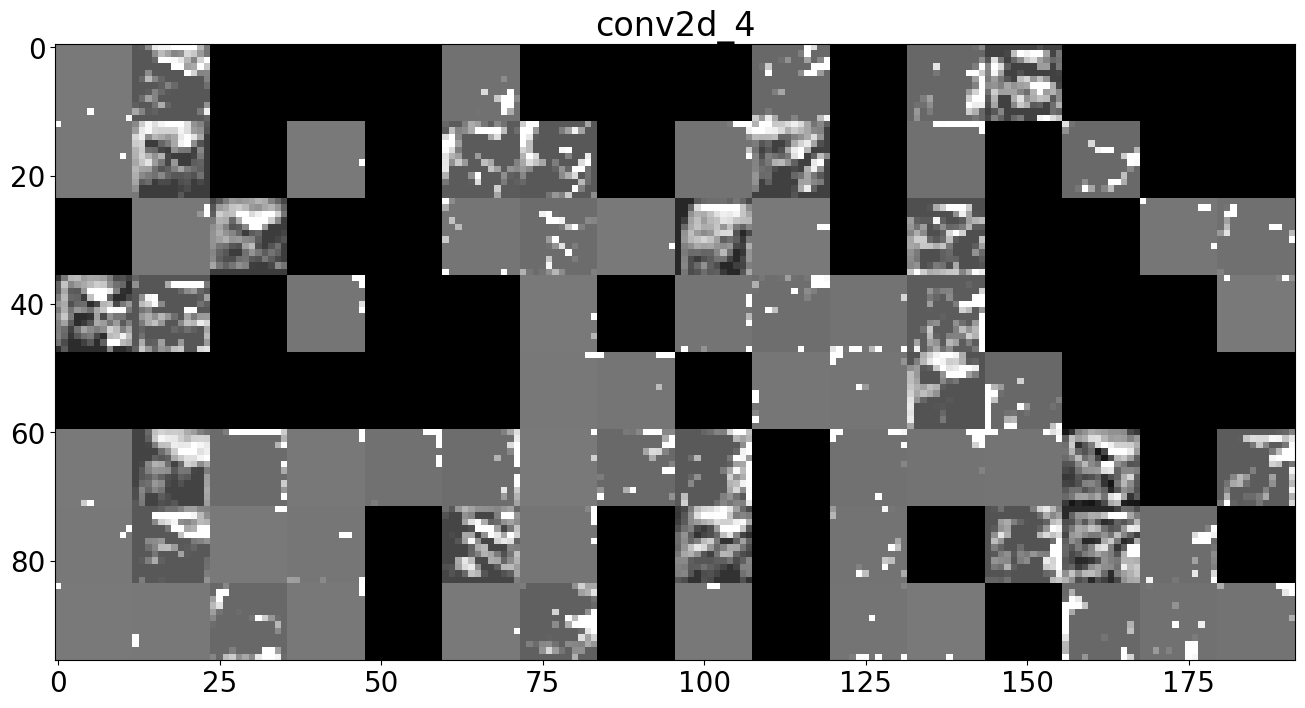

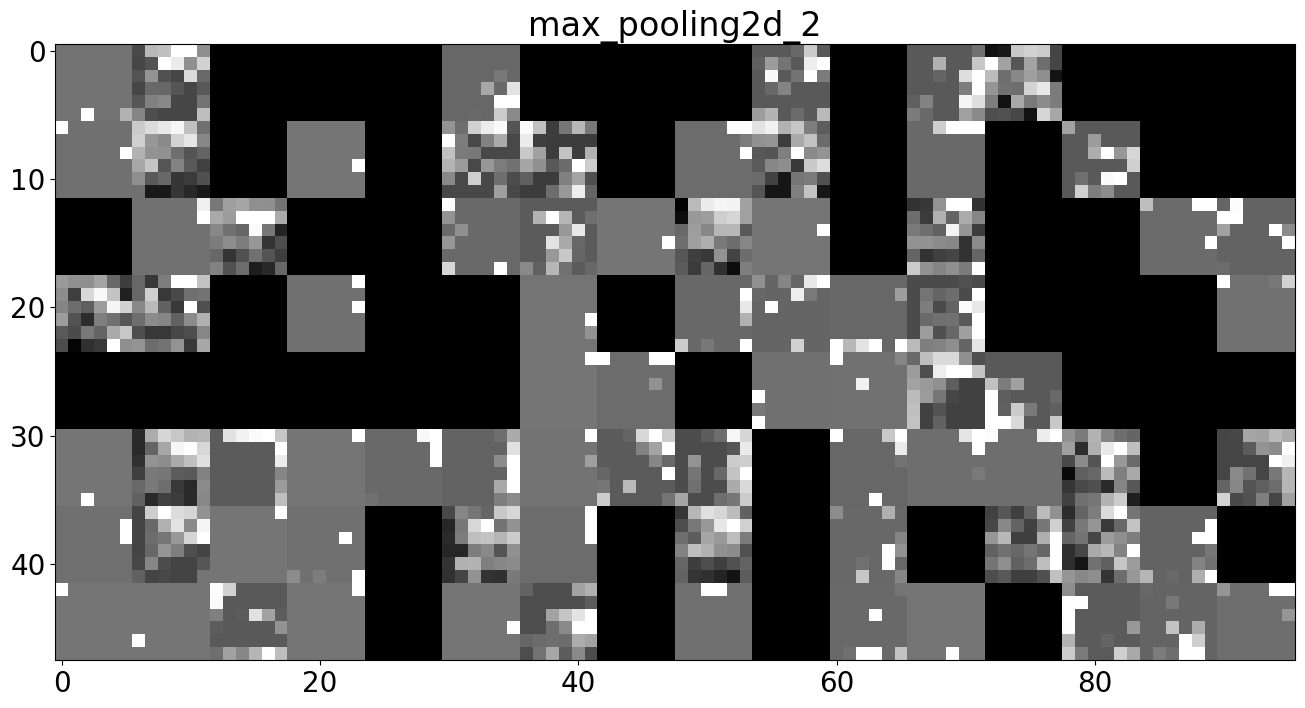

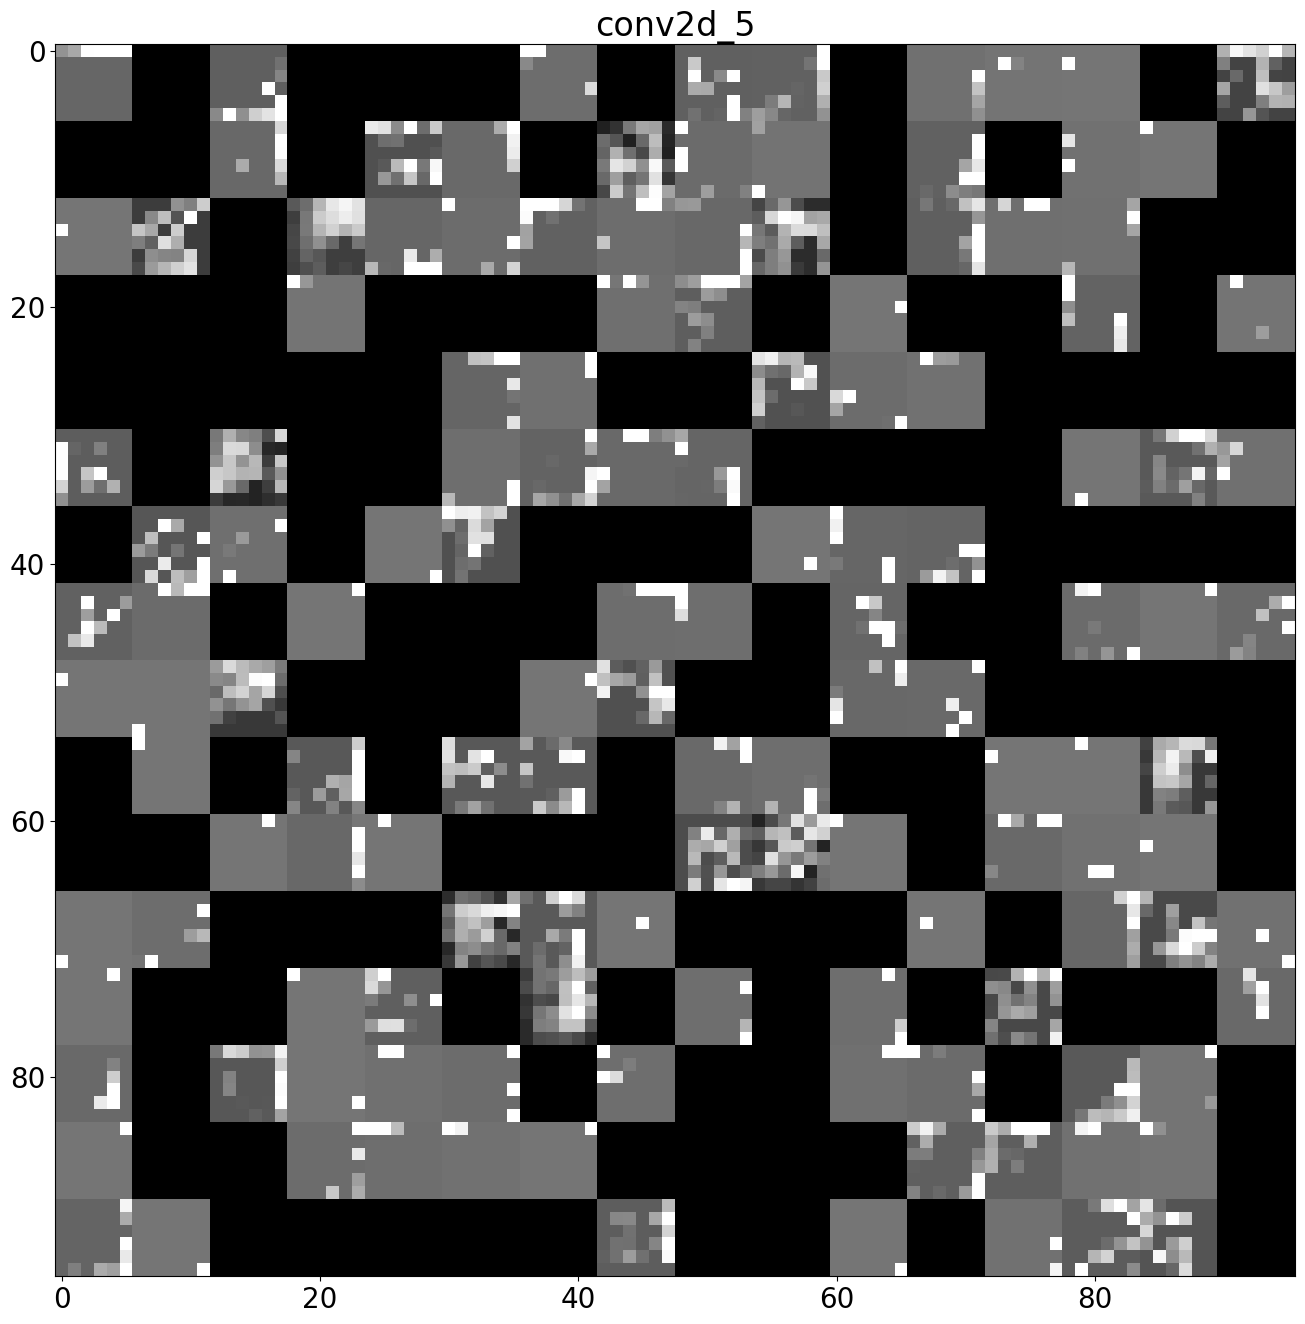

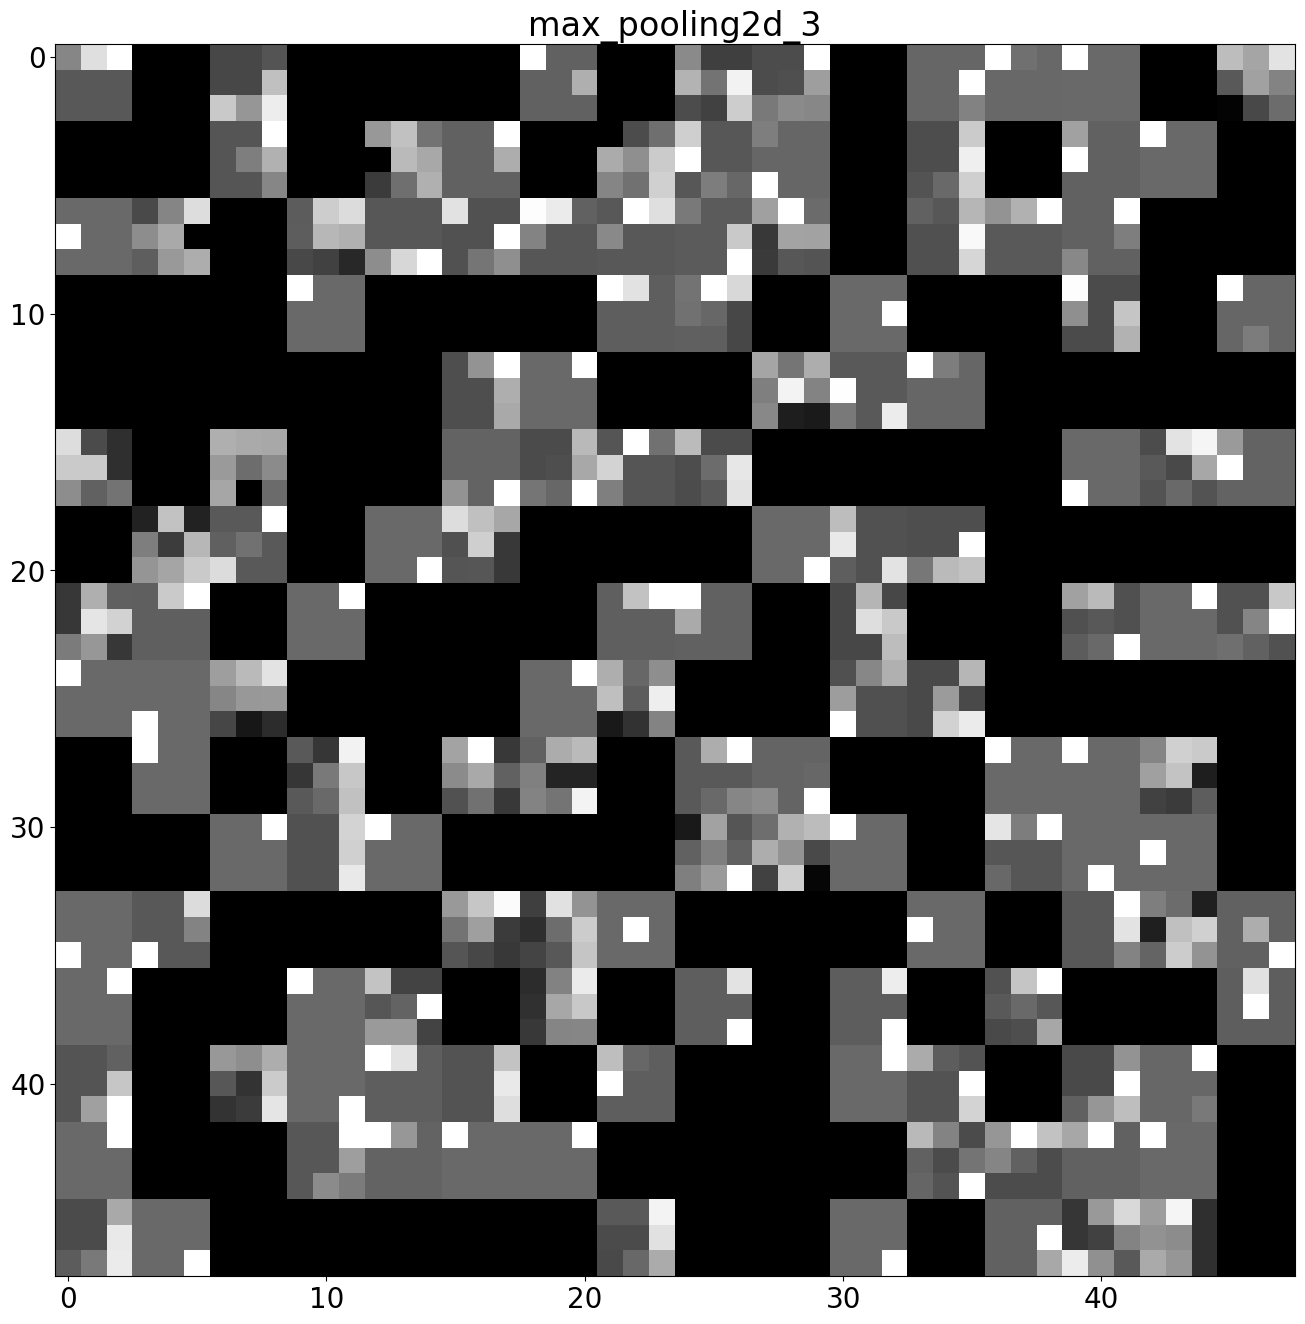

In [ ]:
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :, col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')

plt.show()

# Visualizing heatmaps of class activation

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
img_path = '/content/drive/Shareddrives/Cocchella_Cantini/Dataset/test/3/PrivateTest_1140198.jpg'

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size, color_mode='grayscale')
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_array = get_img_array(img_path, target_size=(48, 48))

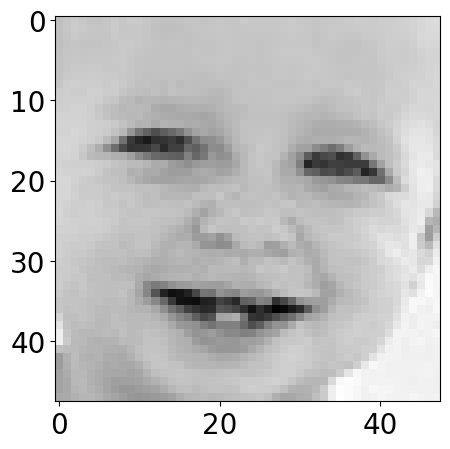

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_array[0].astype('uint8'),cmap="gray")
plt.show()

In [ ]:
img_array /= 255.0

In [ ]:
preds = model.predict(img_array)

1/1 [==============================] - 0s 22ms/step


In [ ]:
print(preds)
np.argmax(preds[0])

[[5.5119669e-04 5.1193960e-09 4.9774591e-03 9.0570354e-01 2.6930317e-02
  6.0829069e-02 1.0085031e-03]]


3

In [ ]:
last_conv_layer_name = "conv2d_5"
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [ ]:
classifier_layer_names = [
    'max_pooling2d_3',
    'batch_normalization_5',
    'dropout_3',
    'flatten',
    'dense',
    'batch_normalization_6',
    'dropout_4',
    'dense_1',
]
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [ ]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array) # output feature maps of the last conv layer.
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    print(top_pred_index)
    print(top_class_channel)

grads = tape.gradient(top_class_channel, last_conv_layer_output)

tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor([0.90570354], shape=(1,), dtype=float32)


In [ ]:
grads.shape # same shape of conv2d_17 output

TensorShape([1, 6, 6, 256])

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # evaluate the mean over the gradient tensor, for each channel separately --> returns a vector of 2048 elements
print(pooled_grads.shape)
weighted_last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    weighted_last_conv_layer_output[:, :, i] *= pooled_grads[i]

(256,)


In [ ]:
heatmap = np.mean(weighted_last_conv_layer_output, axis=-1)

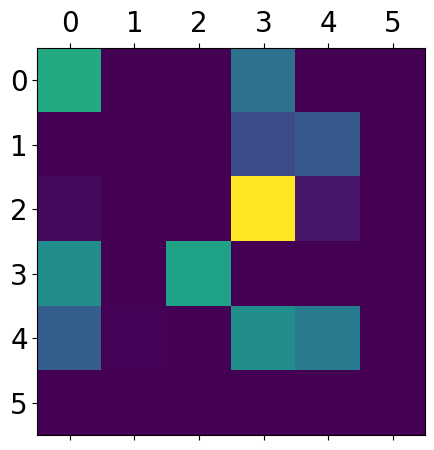

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [ ]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "neutral_sad_2.jpg"
superimposed_img.save(save_path)

<ipython-input-83-9960cfb5257e>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


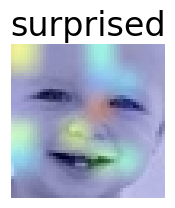

In [ ]:
plt.figure(figsize= (2,2))
plt.axis('off')
plt.title('surprised')
plt.imshow(superimposed_img)

#Pretrained network

## Build network

In [ ]:
#we put all image with classes in np array
image_data = []
image_labels = []

for class_index in classes.keys():
  path = train_path + '/' + str(class_index)
  images = os.listdir(path)

  for img in tqdm(images, desc=f"Class {class_index}"):
        try:
            image_path = path + '/' + img
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_data.append(np.array(image))
            image_labels.append(class_index)
        except:
            print("Error in " + img)

# Convert the list into a numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

Class 6: 100%|██████████| 3171/3171 [00:51<00:00, 62.06it/s] 

(28709, 48, 48, 3) (28709,)


In [ ]:
# salva gli array numpy
np.save('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/image_data_colored_np.npy', image_data)
np.save('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/labels_data_colored_np.npy', image_labels)

In [ ]:
# carica gli array
image_data = np.load('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/image_data_colored_np.npy')
image_labels = np.load('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/labels_data_colored_np.npy')

In [ ]:
#we mix the array, so when we go to create train, test and validation, we avoid having a predominance of classes
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [ ]:
# Split the data and labels into training and validation sets using an 80 - 20 split ratio.
img_train, img_val, label_train, label_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

# Print the shapes of the resulting datasets to confirm the split and normalization.
print("Training data shape:", img_train.shape)
print("Validation data shape:", img_val.shape)
print("Training labels shape:", label_train.shape)
print("Validation labels shape:", label_val.shape)

Training data shape: (22967, 48, 48, 3)
Validation data shape: (5742, 48, 48, 3)
Training labels shape: (22967,)
Validation labels shape: (5742,)


In [ ]:
img_train_norm = img_train.astype('float32') / 255
img_val_norm = img_val.astype('float32') / 255

In [ ]:
# Convert labels to categorical format
categorical_label_train = to_categorical(label_train)
categorical_label_val = to_categorical(label_val)

In [ ]:
aug_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

generator_val = ImageDataGenerator()

In [ ]:
aug_train.fit(img_train_norm)

generator_val.fit(img_val_norm)

In [ ]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

## VGG16


In [ ]:
from tensorflow.keras.applications import VGG16

model = keras.Sequential()

pretrained_model = keras.applications.vgg16.VGG16(include_top=False,
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),classes=7,
                                        weights='imagenet')

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
import numpy as np

print('This is the number of trainable weights '
      'before freezing the conv base:', sum(np.prod(x.shape) for x in pretrained_model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 14714688


In [ ]:
pretrained_model.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', sum(np.prod(x.shape) for x in pretrained_model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
model.add(pretrained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))
# Output layer
model.add(layers.Dense(7, activation='softmax'))
# Compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 14847815 (56.64 MB)
Trainable params: 133127 (520.03 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label_train),
    y=label_train)
class_weight_dict = dict(enumerate(class_weights))

#earlystopping
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 15,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/Shareddrives/Cocchella_Cantini/models/FeatureExtractionVGG16.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True)


In [ ]:
history = model.fit(aug_train.flow(img_train_norm, categorical_label_train, batch_size=64),
                    validation_data=generator_val.flow(img_val_norm, categorical_label_val, batch_size=64),
                    epochs=200,
                    callbacks=[early_stopping, checkpoint],
                    class_weight = class_weight_dict,
                    shuffle = True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 1.8976 - accuracy: 0.2245

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 31s 81ms/step - loss: 1.8976 - accuracy: 0.2245 - val_loss: 1.7998 - val_accuracy: 0.2874
Epoch 2/200
359/359 [==============================] - 29s 81ms/step - loss: 1.8385 - accuracy: 0.2443 - val_loss: 1.7318 - val_accuracy: 0.3286
Epoch 3/200
359/359 [==============================] - 29s 80ms/step - loss: 1.8152 - accuracy: 0.2650 - val_loss: 1.7624 - val_accuracy: 0.2941
Epoch 4/200
359/359 [==============================] - 30s 82ms/step - loss: 1.8024 - accuracy: 0.2652 - val_loss: 1.6802 - val_accuracy: 0.3474
Epoch 5/200
359/359 [==============================] - 29s 82ms/step - loss: 1.7912 - accuracy: 0.2735 - val_loss: 1.7012 - val_accuracy: 0.3351
Epoch 6/200
359/359 [==============================] - 27s 76ms/step - loss: 1.7763 - accuracy: 0.2797 - val_loss: 1.6714 - val_accuracy: 0.3417
Epoch 7/200
359/359 [==============================] - 28s 78ms/step - loss: 1.7794 - accuracy: 0.2810 - val_loss: 1.7150 - val_accuracy: 0.31

## VGG19



In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D

model = keras.Sequential()

pretrained_model = keras.applications.vgg19.VGG19(include_top=False,
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),classes=7,
                                        weights='imagenet')

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
import numpy as np

print('This is the number of trainable weights '
      'before freezing the conv base:', sum(np.prod(x.shape) for x in pretrained_model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 20024384


In [ ]:
pretrained_model.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', sum(np.prod(x.shape) for x in pretrained_model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
model.add(pretrained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))
# Output layer
model.add(layers.Dense(7, activation='softmax'))
# Compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 20157511 (76.89 MB)
Trainable params: 133127 (520.03 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label_train),
    y=label_train)
class_weight_dict = dict(enumerate(class_weights))

#earlystopping
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 15,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/Shareddrives/Cocchella_Cantini/models/FeatureExtractionVGG19.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [ ]:
history = model.fit(aug_train.flow(img_train_norm, categorical_label_train, batch_size=64),
                    validation_data=generator_val.flow(img_val_norm, categorical_label_val, batch_size=64),
                    epochs=200,
                    callbacks=[early_stopping],
                    class_weight = class_weight_dict,
                    shuffle = True)

Epoch 1/200
359/359 [==============================] - 30s 79ms/step - loss: 1.9139 - accuracy: 0.2108 - val_loss: 1.7718 - val_accuracy: 0.3069
Epoch 2/200
359/359 [==============================] - 29s 80ms/step - loss: 1.8525 - accuracy: 0.2345 - val_loss: 1.7839 - val_accuracy: 0.2975
Epoch 3/200
359/359 [==============================] - 28s 79ms/step - loss: 1.8423 - accuracy: 0.2451 - val_loss: 1.7508 - val_accuracy: 0.3128
Epoch 4/200
359/359 [==============================] - 29s 80ms/step - loss: 1.8326 - accuracy: 0.2554 - val_loss: 1.7521 - val_accuracy: 0.3159
Epoch 5/200
359/359 [==============================] - 28s 78ms/step - loss: 1.8201 - accuracy: 0.2475 - val_loss: 1.7428 - val_accuracy: 0.3053
Epoch 6/200
359/359 [==============================] - 28s 79ms/step - loss: 1.8237 - accuracy: 0.2459 - val_loss: 1.7386 - val_accuracy: 0.3184
Epoch 7/200
359/359 [==============================] - 28s 78ms/step - loss: 1.8151 - accuracy: 0.2541 - val_loss: 1.7564 - val_ac

## ResNet50

In [ ]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [ ]:
model = keras.Sequential()

pretrained_model = keras.applications.ResNet50(include_top=False,
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),classes=7,
                                        weights='imagenet')

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
import numpy as np

print('This is the number of trainable weights '
      'before freezing the conv base:', sum(np.prod(x.shape) for x in pretrained_model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 23534592


In [ ]:
pretrained_model.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', sum(np.prod(x.shape) for x in pretrained_model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
model.add(pretrained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))
# Output layer
model.add(layers.Dense(7, activation='softmax'))
# Compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 25686919 (97.99 MB)
Trainable params: 2099207 (8.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label_train),
    y=label_train)
class_weight_dict = dict(enumerate(class_weights))

#earlystopping
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 7,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/Shareddrives/Cocchella_Cantini/models/FeatureExtractionResNet50.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [ ]:
history = model.fit(aug_train.flow(img_train_norm, categorical_label_train, batch_size=64),
                    validation_data=generator_val.flow(img_val_norm, categorical_label_val, batch_size=64),
                    epochs=200,
                    callbacks=[early_stopping, checkpoint],
                    class_weight = class_weight_dict,
                    shuffle = True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 1.9843 - accuracy: 0.1159

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 39s 89ms/step - loss: 1.9843 - accuracy: 0.1159 - val_loss: 1.9469 - val_accuracy: 0.0247
Epoch 2/200
359/359 [==============================] - 29s 80ms/step - loss: 1.9475 - accuracy: 0.0943 - val_loss: 1.9474 - val_accuracy: 0.0164
Epoch 3/200
359/359 [==============================] - 34s 94ms/step - loss: 1.9463 - accuracy: 0.0846 - val_loss: 1.9466 - val_accuracy: 0.1721
Epoch 4/200
359/359 [==============================] - 29s 81ms/step - loss: 1.9466 - accuracy: 0.1075 - val_loss: 1.9467 - val_accuracy: 0.0155
Epoch 5/200
359/359 [==============================] - 29s 80ms/step - loss: 1.9462 - accuracy: 0.1262 - val_loss: 1.9465 - val_accuracy: 0.1721
Epoch 6/200
359/359 [==============================] - 29s 80ms/step - loss: 1.9461 - accuracy: 0.0718 - val_loss: 1.9453 - val_accuracy: 0.1358
Epoch 7/200
359/359 [==============================] - 31s 86ms/step - loss: 1.9460 - accuracy: 0.0841 - val_loss: 1.9448 - val_accuracy: 0.17

## Fine Tuning VGG16



In [ ]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
pretrained_model = keras.applications.vgg16.VGG16(include_top=False,
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),classes=7,
                                        weights='imagenet')


pretrained_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [ ]:
import numpy as np

print('This is the number of trainable weights '
      'before freezing the conv base:', sum(np.prod(x.shape) for x in pretrained_model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 14714688


In [ ]:
pretrained_model.trainable = True

set_trainable = False
for layer in pretrained_model.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after unfreezing the conv base:', sum(np.prod(x.shape) for x in pretrained_model.trainable_weights))

This is the number of trainable weights after unfreezing the conv base: 12979200


In [ ]:
model = keras.Sequential()

model.add(pretrained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
# Output layer
model.add(layers.Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 14847815 (56.64 MB)
Trainable params: 13112327 (50.02 MB)
Non-trainable params: 1735488 (6.62 MB)
_________________________________________________________________


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label_train),
    y=label_train)
class_weight_dict = dict(enumerate(class_weights))

#earlystopping
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.00001,
    patience = 10,
    restore_best_weights = True,
    verbose = 1
)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/Shareddrives/Cocchella_Cantini/models/FineTuningVGG16.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [ ]:
history = model.fit(aug_train.flow(img_train_norm, categorical_label_train, batch_size=64),
                    validation_data=generator_val.flow(img_val_norm, categorical_label_val, batch_size=64),
                    epochs=200,
                    callbacks=[early_stopping, checkpoint],
                    class_weight = class_weight_dict,
                    shuffle = True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 1.9333 - accuracy: 0.2039

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 47s 88ms/step - loss: 1.9333 - accuracy: 0.2039 - val_loss: 1.8325 - val_accuracy: 0.2546
Epoch 2/200
359/359 [==============================] - 32s 90ms/step - loss: 1.7840 - accuracy: 0.2811 - val_loss: 1.6268 - val_accuracy: 0.3824
Epoch 3/200
359/359 [==============================] - 30s 84ms/step - loss: 1.6885 - accuracy: 0.3342 - val_loss: 1.6153 - val_accuracy: 0.3718
Epoch 4/200
359/359 [==============================] - 33s 92ms/step - loss: 1.6189 - accuracy: 0.3680 - val_loss: 1.5283 - val_accuracy: 0.4121
Epoch 5/200
359/359 [==============================] - 32s 90ms/step - loss: 1.5613 - accuracy: 0.3934 - val_loss: 1.4253 - val_accuracy: 0.4464
Epoch 6/200
359/359 [==============================] - 34s 96ms/step - loss: 1.5207 - accuracy: 0.4061 - val_loss: 1.4444 - val_accuracy: 0.4601
Epoch 7/200
359/359 [==============================] - 35s 99ms/step - loss: 1.4853 - accuracy: 0.4233 - val_loss: 1.3557 - val_accuracy: 0.48

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 14847815 (56.64 MB)
Trainable params: 13112327 (50.02 MB)
Non-trainable params: 1735488 (6.62 MB)
_________________________________________________________________


## Test pretrained model

In [ ]:
from sklearn import metrics
import seaborn as sn

def evaluateClassifier(model, testset, actual):
  font = {'size'   : 16}
  plt.rc('font', **font)
  pred = model.predict(testset)

  y_classes = pred.argmax(axis=-1)
  y_classes = to_categorical(y_classes)

  y_test_non_category = [ np.argmax(t) for t in actual ]
  y_predict_non_category = [ np.argmax(t) for t in y_classes ]
  conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
  print(metrics.classification_report(y_test_non_category, y_predict_non_category))

  # plot confusion matrix
  group_counts = ['{:.0f}'.format(value) for value in conf_mat.flatten()]
  group_percentages = [('{:.2f}'.format(value))[1:] for value in (conf_mat / np.sum(conf_mat, axis=1)).flatten()]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(7,7) # 7 is the number of classes
  fig, ax = plt.subplots(figsize=(11,10))
  plt.title('Confusion matrix')
  sn.heatmap(conf_mat, annot=labels, fmt='', cmap="OrRd", ax=ax)
  font = {'size'   : 20}
  plt.rc('font', **font)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()



def plot_accurancy_loss(hist):
  """ utility function to plot training and validation curves"""

  plt.rcParams["figure.figsize"] = (7,5)
  font = {'size'   : 24}
  plt.rc('font', **font)

  acc_1 = hist.history['accuracy']
  val_acc_1 = hist.history['val_accuracy']
  loss_1 = hist.history['loss']
  val_loss_1 = hist.history['val_loss']
  epochs = range(len(acc_1))

  plt.figure()
  plt.plot(epochs, loss_1, 'C1', alpha=0.6, label='Training loss', linewidth=3.5)
  plt.plot(epochs, val_loss_1, 'C2', alpha=0.6, label='Validation loss', linewidth=3.5)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(prop={'size': 24}, loc="upper right")
  plt.show()

  plt.ylim(0,1)
  plt.plot(epochs, acc_1, 'C1', alpha=0.6, linewidth=3.5, label='Training acc')
  plt.plot(epochs, val_acc_1, 'C2', alpha=0.6, linewidth=3.5, label='Validation acc')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(prop={'size': 24}, loc="lower right")

  plt.show()

In [ ]:
#we put all test image with classes in np array
image_test_np = []
label_test_np = []

for class_index in classes.keys():
  path = test_path + '/' + str(class_index)
  images = os.listdir(path)

  for img in tqdm(images, desc=f"Class {class_index}"):
        try:
            image_path = path + '/' + img
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_test_np.append(np.array(image))
            label_test_np.append(class_index)
        except:
            print("Error in " + img)

# Convert the list into a numpy array
image_test_np = np.array(image_test_np)
label_test_np = np.array(label_test_np)


print(image_test_np.shape, label_test_np.shape)

Class 6: 100%|██████████| 831/831 [00:14<00:00, 57.99it/s] 


(7178, 48, 48, 3) (7178,)


In [ ]:

np.save('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/image_test_colored_np.npy', image_test_np)
np.save('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/label_test_colored_np.npy', label_test_np)

In [ ]:
image_test_np = np.load('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/image_test_colored_np.npy')
label_test_np = np.load('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/label_test_colored_np.npy')

In [ ]:
image_test_norm = image_test_np.astype('float32') / 255

(7178, 48, 48, 3)
(7178, 48, 48, 3)
(7178, 48, 48, 3)


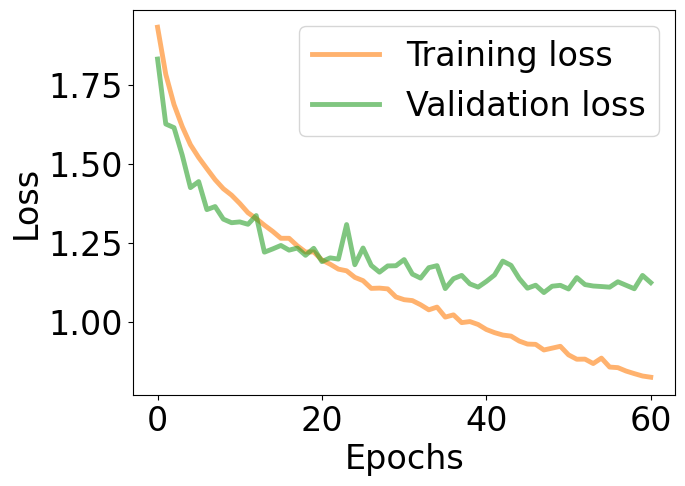

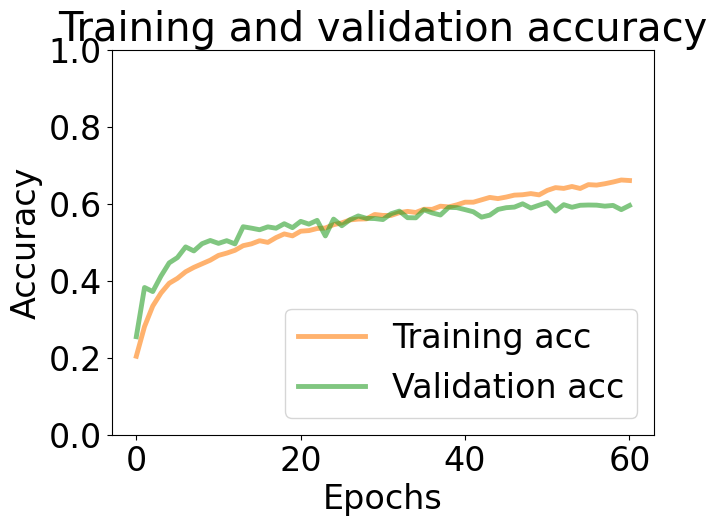

225/225 [==============================] - 4s 13ms/step
              precision    recall  f1-score   support

           0       0.55      0.50      0.52       958
           1       0.49      0.68      0.57       111
           2       0.49      0.32      0.38      1024
           3       0.79      0.83      0.81      1774
           4       0.51      0.61      0.56      1233
           5       0.50      0.45      0.48      1247
           6       0.64      0.80      0.71       831

    accuracy                           0.60      7178
   macro avg       0.57      0.60      0.58      7178
weighted avg       0.60      0.60      0.59      7178



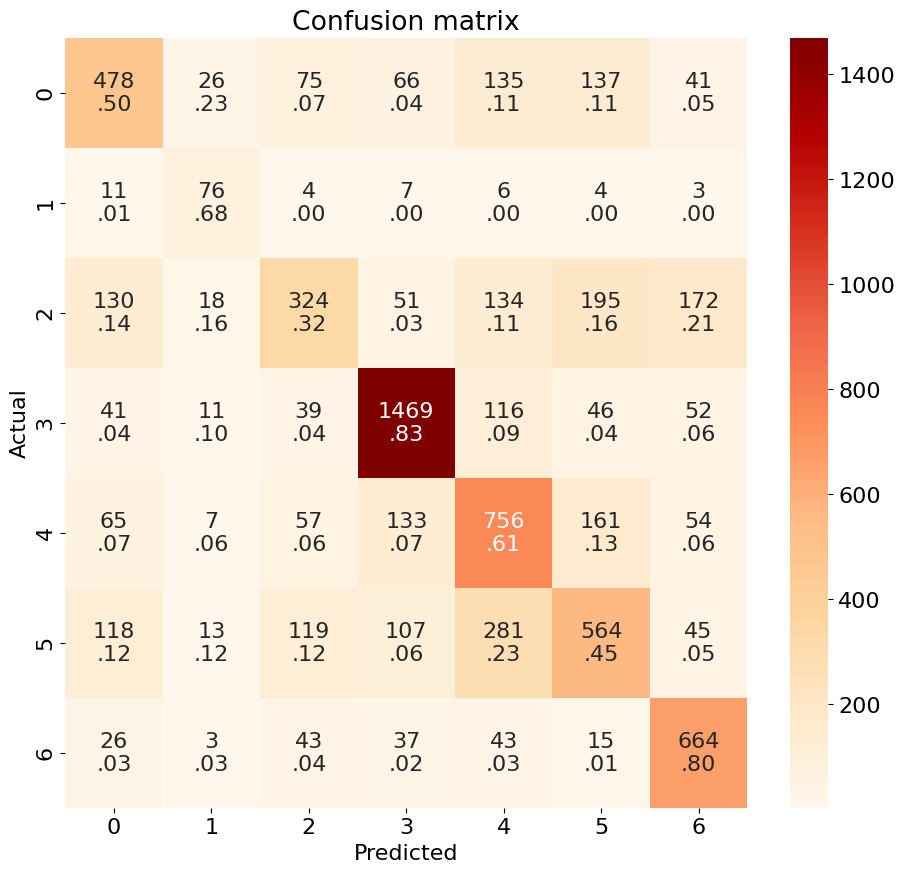

In [ ]:
print(image_test_norm.shape)
# Convert labels to categorical format
categorical_label_test = to_categorical(label_test_np)
# reshape test set
#image_test_norm = image_test_norm.reshape(image_test_norm.shape[0], image_test_norm.shape[1], image_test_norm.shape[2], 1)
print(image_test_norm.shape)
# Reshape of the input into 3 channel
#img_test_rgb = np.repeat(image_test_norm, 3, axis=-1)
print(image_test_norm.shape)
#print(img_test_rgb.shape)

plot_accurancy_loss(history)
#evaluateClassifier(model, img_test_rgb, categorical_label_test)
evaluateClassifier(model, image_test_norm, categorical_label_test)